Copyright © 2021  Sapozhnikov Andrey Mikhailovich  
* * *
**Original file**: https://github.com/NVIDIA/mellotron/blob/master/inference.ipynb  
Changes have been provided to perform inference Tacotron2 + GSTs only.  
(excluding speaker embedding and pitch contour copying)  
**Mellotron (Tacotron2 + GSTs only)**: https://github.com/lightbooster/mellotron/tree/only-gst

# Prepare Environment

In [2]:
!git clone https://github.com/lightbooster/mellotron.git
%cd mellotron
!git checkout only-gst

Cloning into 'mellotron'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 173 (delta 3), reused 4 (delta 2), pack-reused 161
Receiving objects: 100% (173/173), 3.38 MiB | 13.38 MiB/s, done.
Resolving deltas: 100% (73/73), done.
/content/mellotron
Branch 'only-gst' set up to track remote branch 'only-gst' from 'origin'.
Switched to a new branch 'only-gst'


In [3]:
!git submodule init; git submodule update

Submodule 'waveglow' (https://github.com/NVIDIA/waveglow.git) registered for path 'waveglow'
Cloning into '/content/mellotron/waveglow'...
Submodule path 'waveglow': checked out '2fd4e63e2918012f55eac2c8a8e75622a39741be'


In [4]:
!pip install apex
!pip install Unidecode
!pip install tensorflow==1.15.2

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 716kB 23.9MB/s 
     |████████████████████████████████| 256kB 31.4MB/s 
     |████████████████████████████████| 174kB 53.4MB/s 
     |████████████████████████████████| 51kB 9.3MB/s 
     |████████████████████████████████| 256kB 50.0MB/s 
     |████████████████████████████████| 143kB 48.5MB/s 
     |████████████████████████████████| 122kB 54.3MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
  Created wheel for cryptacular: filename=cryptacular-1.5.5-cp37-abi3-manylinux2010_x86_64.whl size=48278 sha256=b714fafdc0d434ef8adc1f86b3dcebd6fb5c27cfd94ff1f92bcd2ee1cffb4a57
  Stored in directory: /root/.cache/pip/wheels/3c/79/bc/1eec7120c3ff9b0a2c7ad94d1626abc3388688e2ed7a45878f
Successfully built cryptacular
  Created wheel for apex: filename=apex-0.9.10.dev0-cp37-none-any.whl size=46468 sha256=0a32b7db5e6ef09195c7a420f0

### Google Drive mount

Goodle Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')
DRIVE_PATH = "/content/drive/MyDrive/"

Mounted at /content/drive


## Libs & Imports

In [7]:
%cd /content/mellotron/

/content/mellotron


In [8]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd

import sys
sys.path.append('waveglow/')

from itertools import cycle
import numpy as np
import scipy as sp
from scipy.io.wavfile import write
import pandas as pd
import librosa
import torch

from hparams import create_hparams
from model import Tacotron2, load_model
from waveglow.denoiser import Denoiser
from layers import TacotronSTFT
from data_utils import TextMelLoader, TextMelCollate
from text import cmudict, text_to_sequence
from mellotron_utils import get_data_from_musicxml

In [9]:
def panner(signal, angle):
    angle = np.radians(angle)
    left = np.sqrt(2)/2.0 * (np.cos(angle) - np.sin(angle)) * signal
    right = np.sqrt(2)/2.0 * (np.cos(angle) + np.sin(angle)) * signal
    return np.dstack((left, right))[0]

In [10]:
def plot_mel_alignment(mel_source, mel_outputs_postnet, alignments, figsize=(16, 16)):
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    axes = axes.flatten()
    axes[0].imshow(mel_source, aspect='auto', origin='bottom', interpolation='none')
    axes[1].imshow(mel_outputs_postnet, aspect='auto', origin='bottom', interpolation='none')
    axes[2].imshow(alignments, aspect='auto', origin='bottom', interpolation='none')
    axes[0].set_title("Source Mel")
    axes[1].set_title("Predicted Mel")
    axes[2].set_title("Source rhythm")
    plt.tight_layout()

In [11]:
def load_mel(path):
    audio, sampling_rate = librosa.core.load(path, sr=hparams.sampling_rate)
    audio = torch.from_numpy(audio)
    if sampling_rate != hparams.sampling_rate:
        raise ValueError("{} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))
    audio_norm = audio.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    melspec = melspec.cuda()
    return melspec

# Eval

In [12]:
hparams = create_hparams()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [13]:
stft = TacotronSTFT(hparams.filter_length, hparams.hop_length, hparams.win_length,
                    hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                    hparams.mel_fmax)

## Mellotron

Modify Mellotron checkpoint to correspond the Tacotron2 + GSTs model

Load checkpoint

In [14]:
checkpoint_path = DRIVE_PATH + "ModelsCheckpoints/mellotron_ljs.pt"
checkpoint = torch.load(checkpoint_path)
state_dict = checkpoint['state_dict']

Modify state dict

In [15]:
# Pop
state_dict.pop('speaker_embedding.weight')
state_dict.pop('decoder.prenet_f0.conv.weight')

# Trim
state_dict['decoder.attention_rnn.weight_ih'] = \
state_dict['decoder.attention_rnn.weight_ih'].narrow(1, 0, 1024)

state_dict['decoder.attention_layer.memory_layer.linear_layer.weight'] = \
state_dict['decoder.attention_layer.memory_layer.linear_layer.weight'].narrow(1, 0, 768)

state_dict['decoder.decoder_rnn.weight_ih'] = \
state_dict['decoder.decoder_rnn.weight_ih'].narrow(1, 0, 1792)

state_dict['decoder.linear_projection.linear_layer.weight'] = \
state_dict['decoder.linear_projection.linear_layer.weight'].narrow(1, 0, 1792)

state_dict['decoder.gate_layer.linear_layer.weight'] = \
state_dict['decoder.gate_layer.linear_layer.weight'].narrow(1, 0, 1792)

Load state dict to a model

In [16]:
mellotron = load_model(hparams).cuda().eval()
mellotron.load_state_dict(state_dict)

<All keys matched successfully>

## WaveGlow

In [17]:
waveglow_path = DRIVE_PATH + "ModelsCheckpoints/waveglow_256channels_universal_v4.pt"
waveglow = torch.load(waveglow_path)['model'].cuda().eval()
denoiser = Denoiser(waveglow).cuda().eval()

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or

## Setup dataloaders

In [18]:
arpabet_dict = cmudict.CMUDict('data/cmu_dictionary')
audio_paths = 'data/examples_filelist.txt'
dataloader = TextMelLoader(audio_paths, hparams)
datacollate = TextMelCollate(1)

## Load data

In [19]:
file_idx = 0
audio_path, text, sid = dataloader.audiopaths_and_text[file_idx]

# get audio path, encoded text, pitch contour and mel for gst
text_encoded = torch.LongTensor(text_to_sequence(text, hparams.text_cleaners, arpabet_dict))[None, :].cuda()    
mel = load_mel(audio_path)
print(audio_path, text)

# load source data to obtain rhythm using tacotron 2 as a forced aligner
x, y = mellotron.parse_batch(datacollate([dataloader[file_idx]]))

data/example1.wav exploring the expanses of space to keep our planet safe


In [20]:
ipd.Audio(audio_path, rate=hparams.sampling_rate)

In [21]:
x

(tensor([[145, 153, 168, 166, 154, 115, 167, 145, 157,   8, 128, 110,   8, 145,
          153, 168, 166, 107, 156, 168, 145, 183,   8, 111, 180,   8, 168, 166,
          139, 168,   8, 170, 178,   8, 153, 150, 166,   8, 119, 134,   8, 166,
          154, 107, 156, 110, 170,   8, 168, 139, 141]], device='cuda:0'),
 tensor([51], device='cuda:0'),
 tensor([[[ -6.1974,  -5.6973,  -5.8164,  ...,  -4.4820,  -4.3939,  -5.0746],
          [ -6.7440,  -5.5365,  -4.3589,  ...,  -4.6080,  -4.6072,  -5.3200],
          [ -6.2189,  -5.3365,  -4.2016,  ...,  -5.3071,  -5.0197,  -5.4305],
          ...,
          [-10.3804,  -9.5551,  -8.1752,  ..., -10.4715, -10.2128, -10.3555],
          [-10.4665,  -9.2635,  -8.3367,  ..., -10.4089, -10.4013, -10.3220],
          [-10.3404,  -8.8286,  -7.2513,  ..., -10.4941, -10.6084, -10.5577]]],
        device='cuda:0'),
 51,
 tensor([345], device='cuda:0'))

In [22]:
y

(tensor([[[ -6.1974,  -5.6973,  -5.8164,  ...,  -4.4820,  -4.3939,  -5.0746],
          [ -6.7440,  -5.5365,  -4.3589,  ...,  -4.6080,  -4.6072,  -5.3200],
          [ -6.2189,  -5.3365,  -4.2016,  ...,  -5.3071,  -5.0197,  -5.4305],
          ...,
          [-10.3804,  -9.5551,  -8.1752,  ..., -10.4715, -10.2128, -10.3555],
          [-10.4665,  -9.2635,  -8.3367,  ..., -10.4089, -10.4013, -10.3220],
          [-10.3404,  -8.8286,  -7.2513,  ..., -10.4941, -10.6084, -10.5577]]],
        device='cuda:0'),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

# Style Transfer

In [23]:
with torch.no_grad():
    # get rhythm (alignment map) using tacotron 2
    mel_outputs, mel_outputs_postnet, gate_outputs, rhythm = mellotron.forward(x)
    rhythm = rhythm.permute(1, 0, 2)

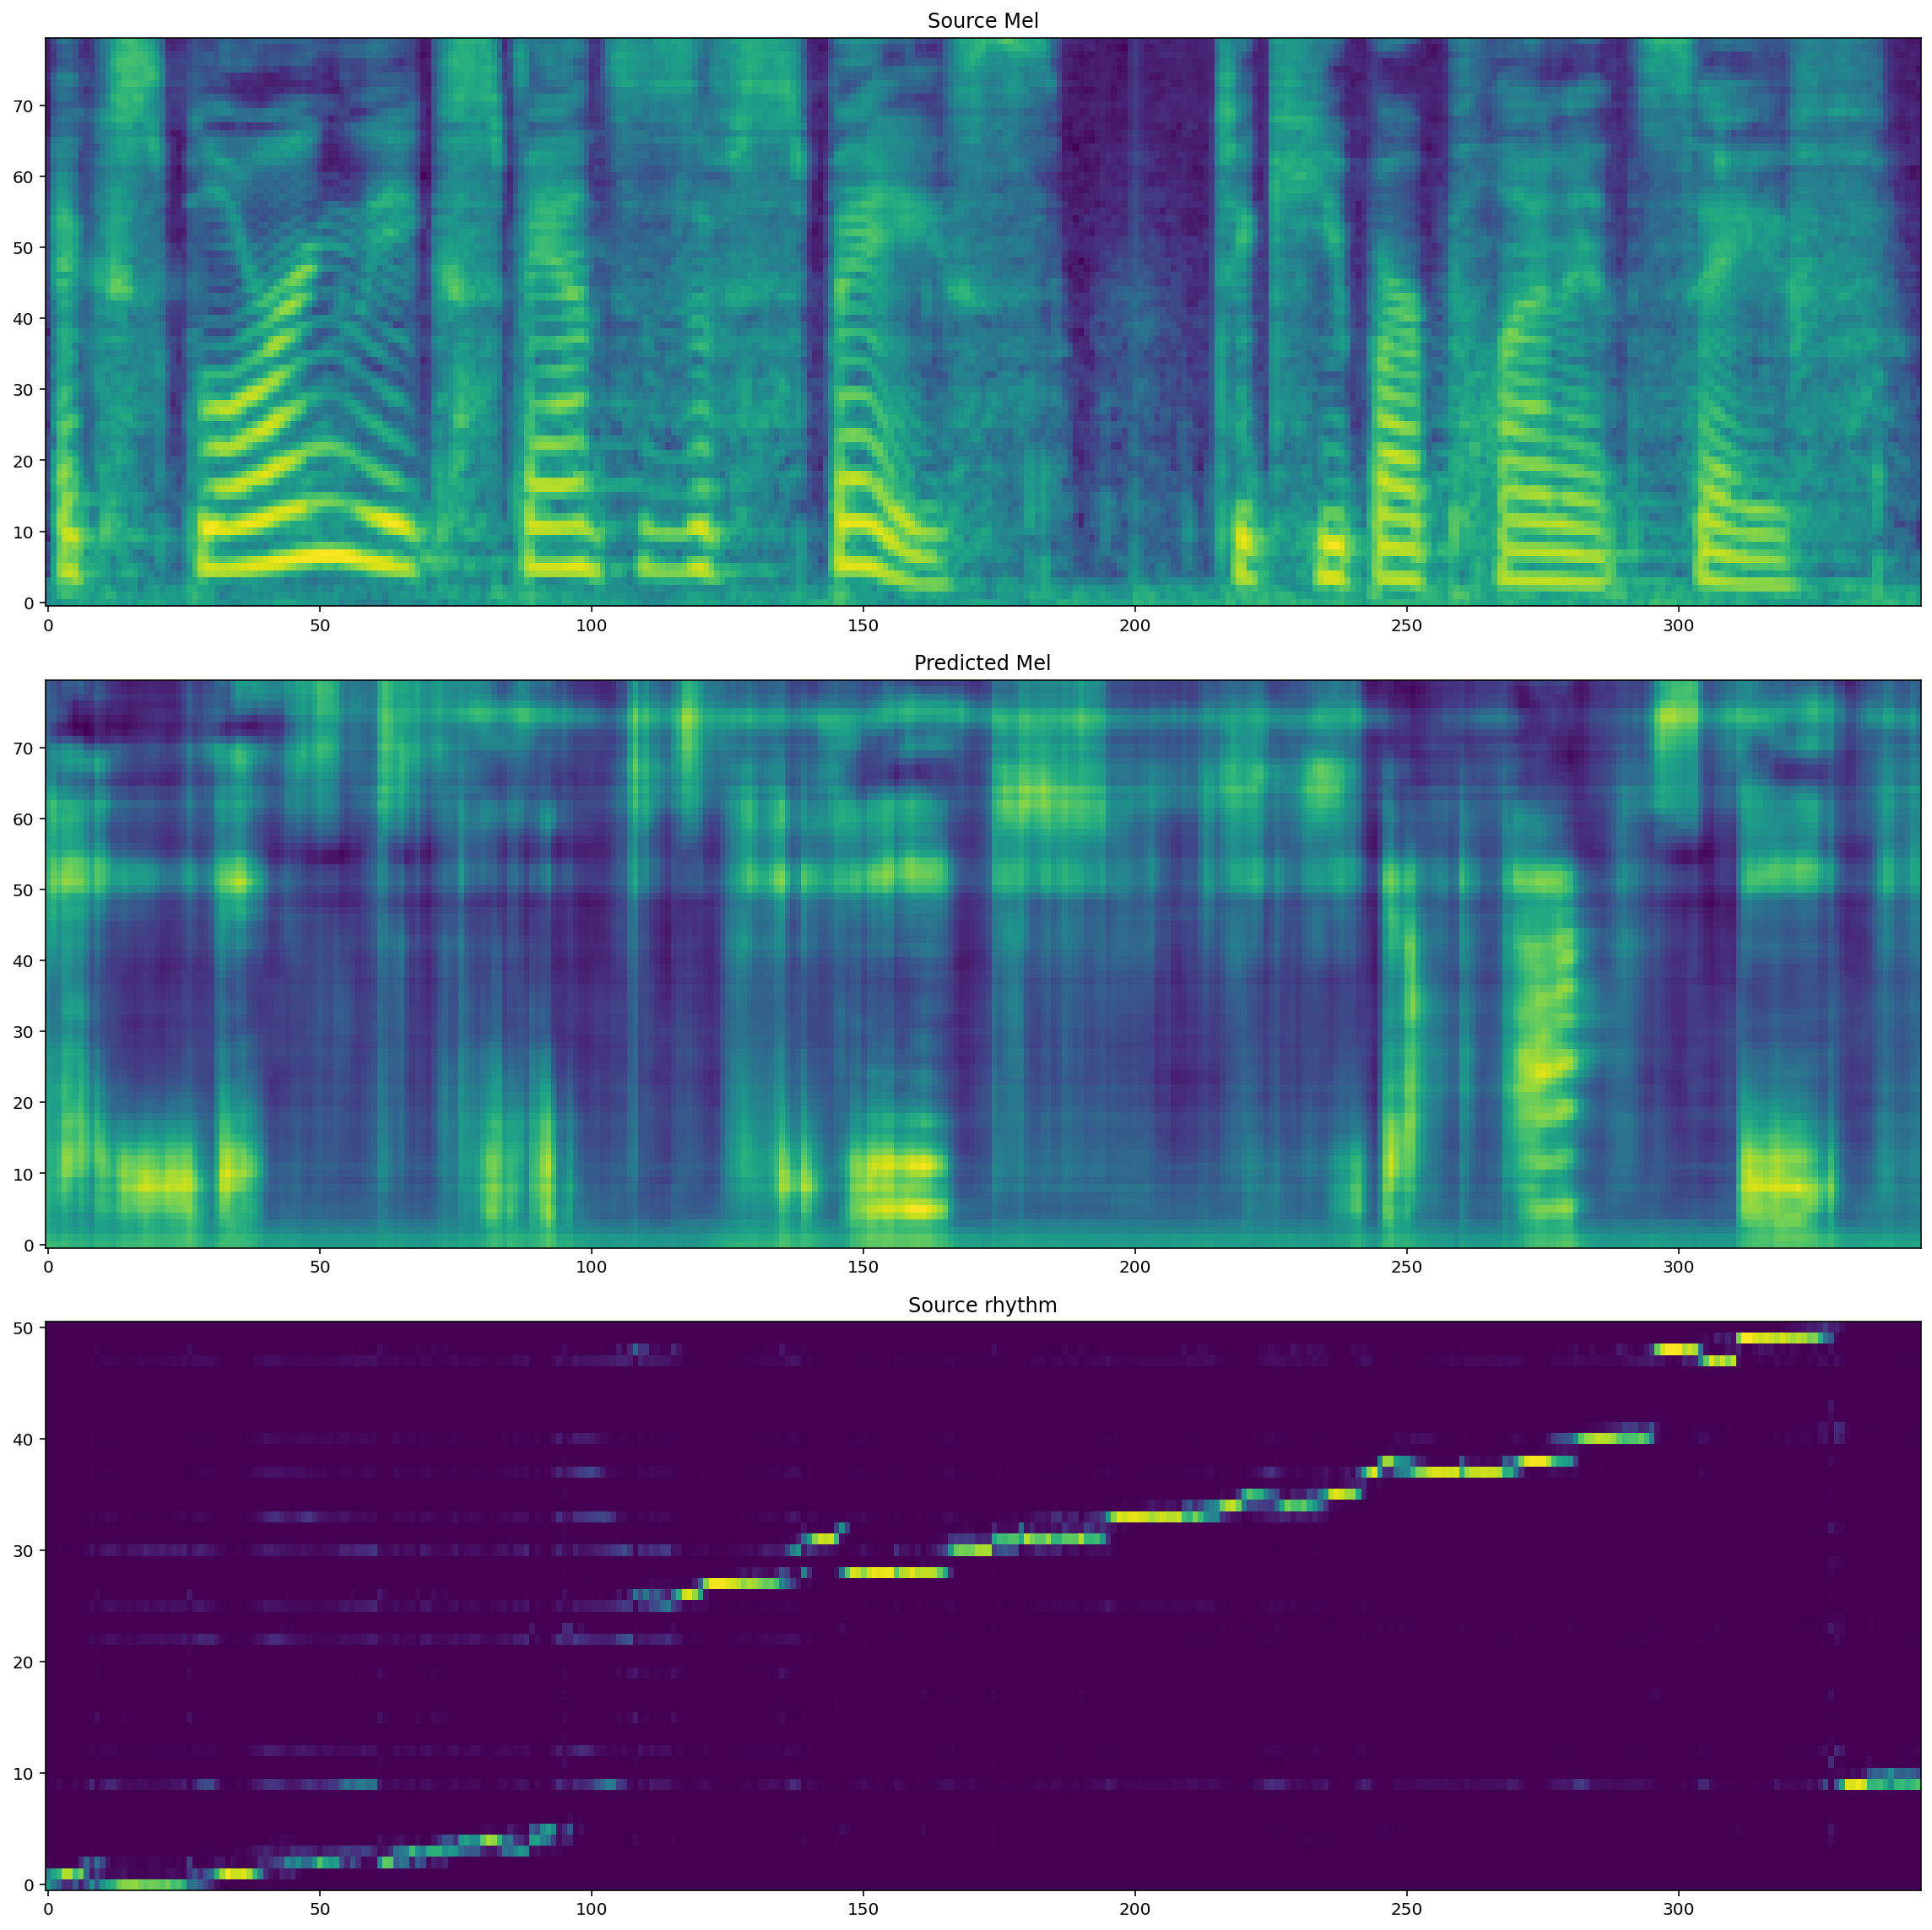

In [25]:
with torch.no_grad():
    mel_outputs, mel_outputs_postnet, gate_outputs, _ = \
        mellotron.inference_noattention((text_encoded, mel, rhythm))

plot_mel_alignment(x[2].data.cpu().numpy()[0],
                      mel_outputs_postnet.data.cpu().numpy()[0],
                      rhythm.data.cpu().numpy()[:, 0].T)

In [26]:
with torch.no_grad():
    audio = denoiser(waveglow.infer(mel_outputs_postnet, sigma=0.8), 0.01)[:, 0]
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)